In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from sklearn.metrics import accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading data
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# Split data into training and validation sets
val_size = int(0.2 * len(train_data))
train_size = len(train_data) - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Using device: cuda


In [30]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [31]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def visualize_performance_and_images(model, val_accuracies, val_loader, class_names):
    # Plot validation accuracies
    epochs = range(1, len(val_accuracies) + 1)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

    # Images
    model.eval()
    with torch.no_grad():
        class_images = {}
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for j in range(len(inputs)):
                image = inputs[j].cpu().numpy().transpose((1, 2, 0))
                image = np.clip(image, 0, 1)
                true_class = class_names[labels[j].item()]
                pred_class = class_names[predicted[j].item()]

                if true_class not in class_images:
                    class_images[true_class] = (image, pred_class)
                else:
                    class_images[true_class] = (image, pred_class)
                    break

        for true_class, (image, pred_class) in class_images.items():
            plt.imshow(image)
            plt.title(f'True Class: {true_class}, Predicted Class: {pred_class}')
            plt.axis('off')
            plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model_resnet18 = ResNet18(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.001)

val_accuracies = []
for epoch in range(10):
    model_resnet18.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet18.zero_grad()
        outputs = model_resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet18.step()
        running_loss += loss.item() * inputs.size(0)

    # Average loss
    train_loss = running_loss / len(train_loader.dataset)

    model_resnet18.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet18(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
resnet_accuracy = evaluate_model(model_resnet18, test_loader)
print(f'Accuracy of Resnet-18 model on test data: {resnet_accuracy:.2f}%')

Epoch 1, Training Loss: 0.8520, Validation Accuracy: 28.98%


Epoch 2, Training Loss: 0.6584, Validation Accuracy: 55.87%


Epoch 3, Training Loss: 0.5914, Validation Accuracy: 66.20%


Epoch 4, Training Loss: 0.4961, Validation Accuracy: 68.30%


Epoch 5, Training Loss: 0.4542, Validation Accuracy: 46.41%


Epoch 6, Training Loss: 0.3925, Validation Accuracy: 73.29%


Epoch 7, Training Loss: 0.3230, Validation Accuracy: 75.22%


Epoch 8, Training Loss: 0.3084, Validation Accuracy: 83.63%


Epoch 9, Training Loss: 0.2498, Validation Accuracy: 90.89%


Epoch 10, Training Loss: 0.2338, Validation Accuracy: 75.57%
Accuracy of Resnet-18 model on test data: 75.36%


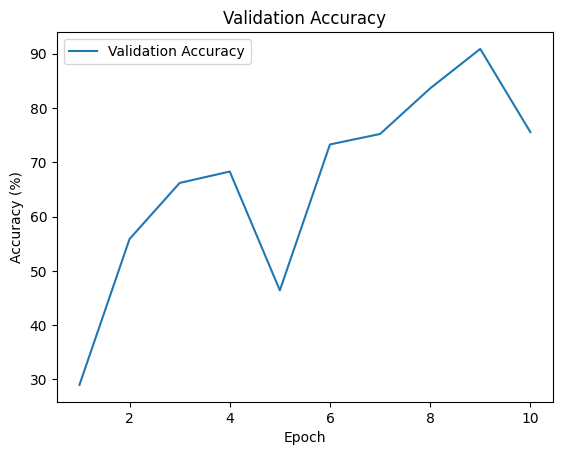

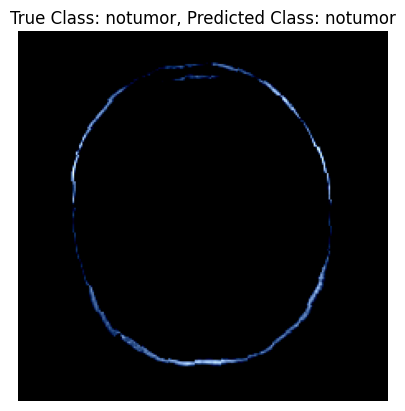

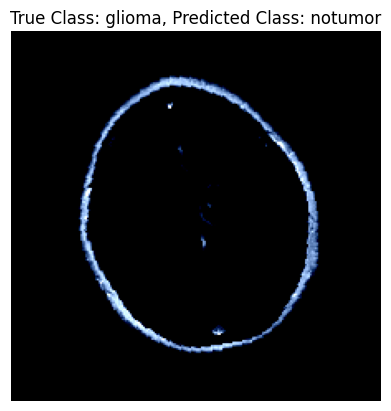

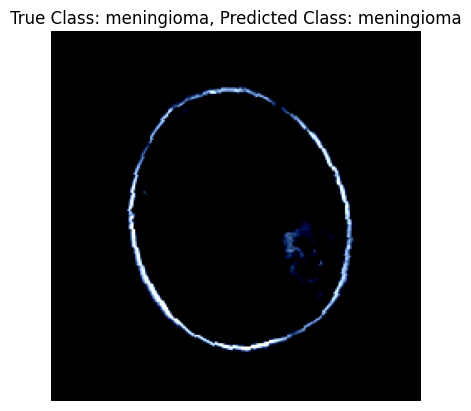

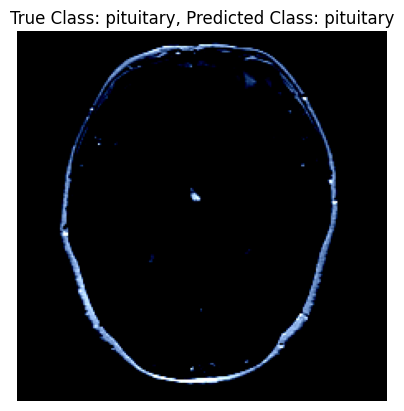

In [33]:
visualize_performance_and_images(model_resnet18, val_accuracies, val_loader, train_data.dataset.classes)

In [34]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        
    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = torch.cat([x, out], 1)
        return out

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv(out)
        out = self.avgpool(out)
        return out

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_classes=4):
        super(DenseNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        num_features = 64
        for i, num_layers in enumerate(block_config):
            block = self._make_dense_block(num_features, growth_rate, num_layers)
            self.features.add_module(f'DenseBlock_{i+1}', block)
            num_features += num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = self._make_transition(num_features, num_features // 2)
                self.features.add_module(f'TransitionBlock_{i+1}', trans)
                num_features = num_features // 2
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features, num_classes)
        
    def _make_dense_block(self, in_channels, growth_rate, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(DenseBlock(in_channels + i * growth_rate, growth_rate))
        return nn.Sequential(*layers)
    
    def _make_transition(self, in_channels, out_channels):
        return TransitionBlock(in_channels, out_channels)
    
    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

model_densenet = DenseNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_densenet = optim.Adam(model_densenet.parameters(), lr=0.001)

for epoch in range(10):
    model_densenet.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_densenet.zero_grad()
        outputs = model_densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_densenet.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model_densenet.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_densenet(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation accuracy after epoch {epoch+1}: {val_accuracy:.2f}%')
    
dense_accuracy = evaluate_model(model_densenet, test_loader)
print(f'Accuracy of DenseNet model on test data: {dense_accuracy:.2f}%')

Validation accuracy after epoch 1: 46.85%


Validation accuracy after epoch 2: 72.15%


Validation accuracy after epoch 3: 73.47%


Validation accuracy after epoch 4: 75.13%


Validation accuracy after epoch 5: 78.46%


Validation accuracy after epoch 6: 27.32%


Validation accuracy after epoch 7: 88.09%


Validation accuracy after epoch 8: 79.86%


Validation accuracy after epoch 9: 87.48%


Epoch 10:  73%|███████▎  | 104/143 [00:41<00:15,  2.56it/s]

Validation accuracy after epoch 10: 82.40%
Accuracy of DenseNet model on test data: 83.45%


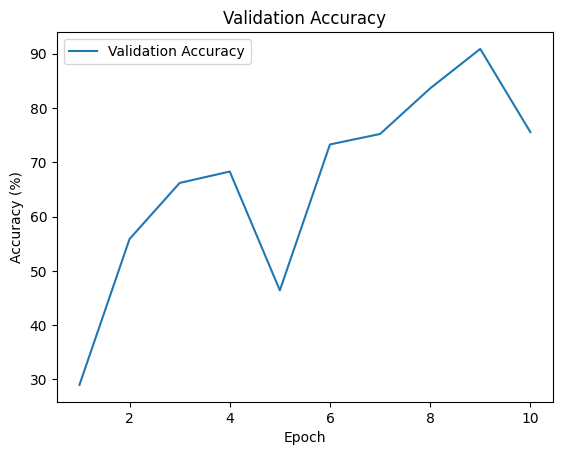

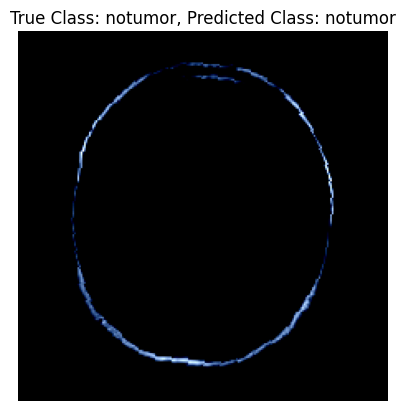

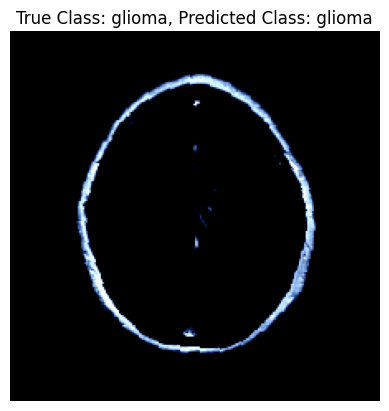

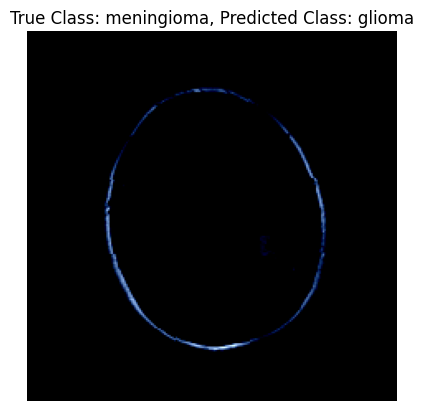

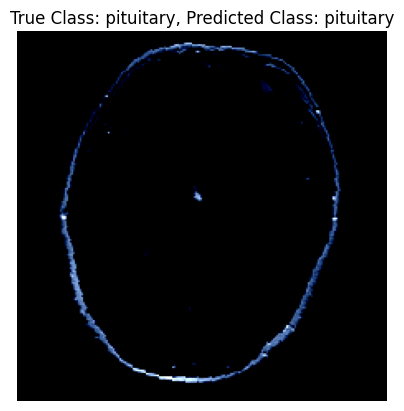

In [35]:
visualize_performance_and_images(model_densenet, val_accuracies, val_loader, train_data.dataset.classes)

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1).to(device)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1).to(device) 
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128).to(device) 
        self.fc2 = nn.Linear(128, 4).to(device) 

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):  
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    model.eval()  
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f'Validation accuracy after epoch {epoch+1}: {val_accuracy:.2f}%')

cnn_accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of CNN model on test data: {cnn_accuracy:.2f}%')

Epoch 1, Batch 100, Loss: 1.4656
Validation accuracy after epoch 1: 80.47%
Epoch 2, Batch 100, Loss: 0.5012
Validation accuracy after epoch 2: 83.80%
Epoch 3, Batch 100, Loss: 0.3774
Validation accuracy after epoch 3: 82.40%
Epoch 4, Batch 100, Loss: 0.3146
Validation accuracy after epoch 4: 89.05%
Epoch 5, Batch 100, Loss: 0.2619
Validation accuracy after epoch 5: 90.11%
Epoch 6, Batch 100, Loss: 0.2039
Validation accuracy after epoch 6: 90.28%
Epoch 7, Batch 100, Loss: 0.1718
Validation accuracy after epoch 7: 89.05%
Epoch 8, Batch 100, Loss: 0.1346
Validation accuracy after epoch 8: 92.91%
Epoch 9, Batch 100, Loss: 0.1333
Validation accuracy after epoch 9: 92.91%
Epoch 10, Batch 100, Loss: 0.0993
Validation accuracy after epoch 10: 92.82%
Accuracy of CNN model on test data: 92.68%


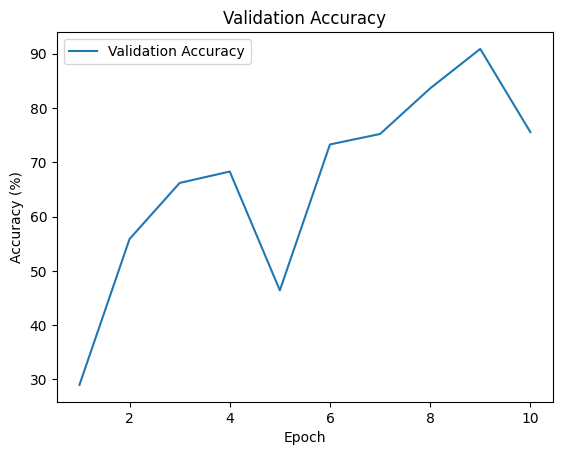

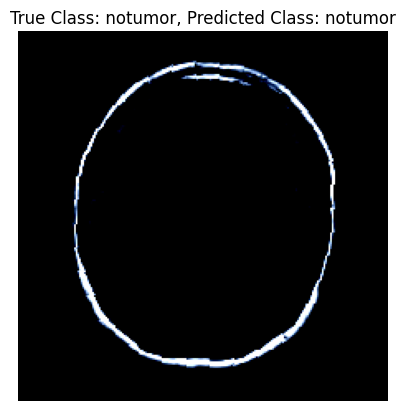

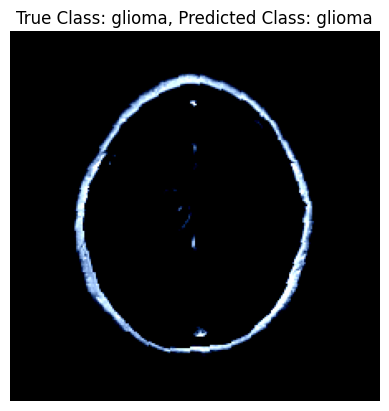

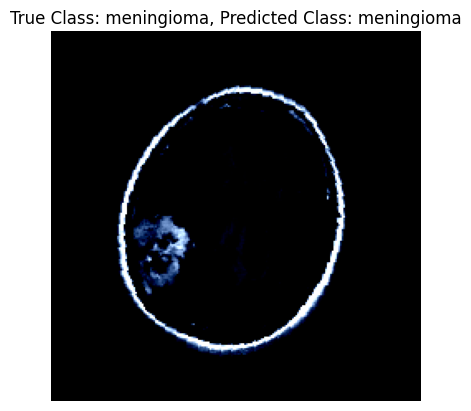

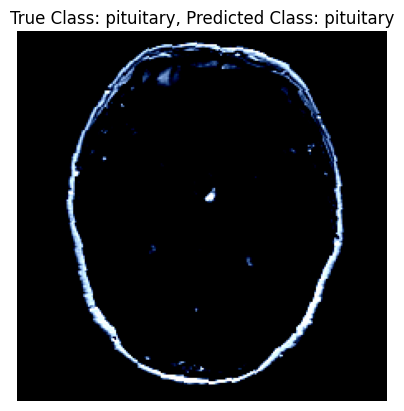

In [37]:
visualize_performance_and_images(model, val_accuracies, val_loader, train_data.dataset.classes)

In [38]:
class MultiscaleCNN(nn.Module):
    def __init__(self):
        super(MultiscaleCNN, self).__init__()
        self.conv1_3x3 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv1_5x5 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv1_7x7 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(48, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x_3x3 = torch.relu(self.conv1_3x3(x))
        x_5x5 = torch.relu(self.conv1_5x5(x))
        x_7x7 = torch.relu(self.conv1_7x7(x))
        x = torch.cat([x_3x3, x_5x5, x_7x7], dim=1)  
        x = self.pool(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_multiscale_cnn = MultiscaleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_multiscale_cnn = optim.Adam(model_multiscale_cnn.parameters(), lr=0.001)

for epoch in range(10):
    model_multiscale_cnn.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_multiscale_cnn.zero_grad()
        outputs = model_multiscale_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_multiscale_cnn.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model_multiscale_cnn.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_multiscale_cnn(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

multi_cnn_accuracy = evaluate_model(model_multiscale_cnn, test_loader)
print(f'Accuracy of CNN model on test data: {multi_cnn_accuracy:.2f}%')

Epoch 1, Training Loss: 0.8906, Validation Accuracy: 77.50%


Epoch 2, Training Loss: 0.4929, Validation Accuracy: 83.89%


Epoch 3, Training Loss: 0.3796, Validation Accuracy: 87.48%


Epoch 4, Training Loss: 0.3012, Validation Accuracy: 87.48%


Epoch 5, Training Loss: 0.2350, Validation Accuracy: 89.14%


Epoch 6, Training Loss: 0.1875, Validation Accuracy: 90.98%


Epoch 7, Training Loss: 0.1743, Validation Accuracy: 91.42%


Epoch 8, Training Loss: 0.1426, Validation Accuracy: 89.75%


Epoch 9, Training Loss: 0.1244, Validation Accuracy: 92.73%


Epoch 10, Training Loss: 0.0896, Validation Accuracy: 91.16%
Accuracy of CNN model on test data: 92.30%


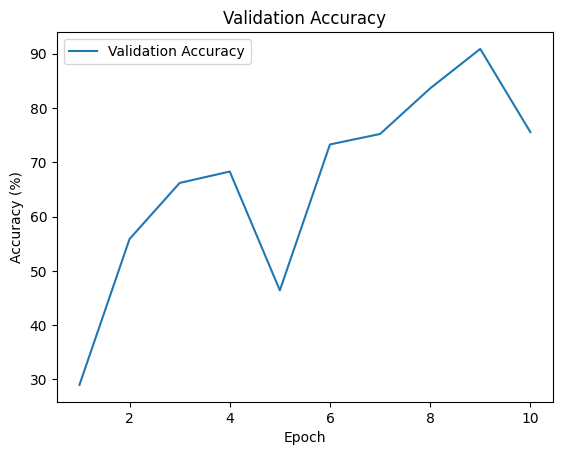

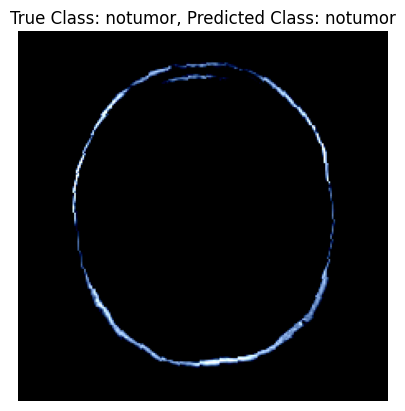

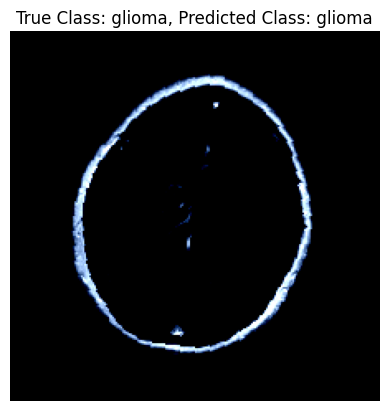

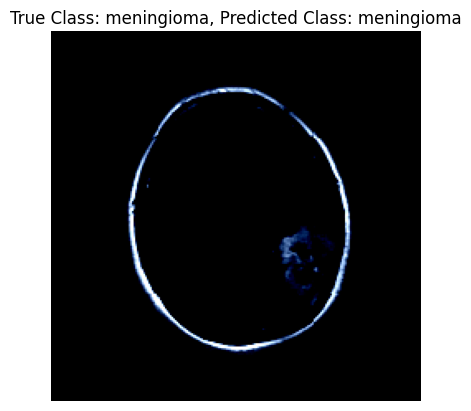

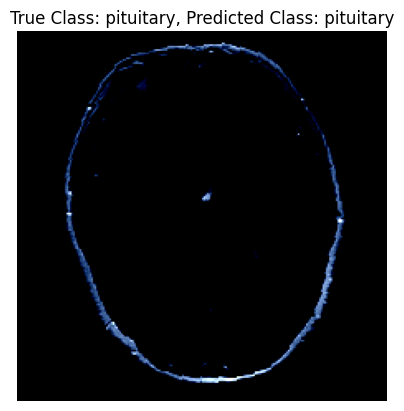

In [ ]:
visualize_performance_and_images(model_multiscale_cnn, val_accuracies, val_loader, train_data.dataset.classes)